In [1]:
#Dependencies
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder 
from sklearn.compose import ColumnTransformer
import tensorflow as tf
from tensorflow import keras
print("Tensorflow Version:",tf.__version__)
print("Keras Version", keras.__version__)

Tensorflow Version: 2.1.0
Keras Version 2.2.4-tf


In [2]:
#File directory
ser_path = "./serialized/"
#change directory to datasets
os.chdir("../datasets")

In [3]:
#Import Dataframe
monthly = pd.read_pickle(ser_path + "structuralmonthly_with_indicators.pkl")
monthly.head()

,calendar_day,year,month,global_steel_utilization,fed_construction$B,state_local_construction$B,carbon_bar_ship_usa,carbon_bar_ship_canada,structural_ship_usa,structural_ship_canada,ism_manufacturing,ism_non_manufacturing,chicago_scrap$ST,block,IN_tons,PR_ton,SO_order_qty_sales_units,SH_shipment_tons
0,2016-01-31,2016,1,0.66,1583.0,16684.0,204300.0,30800.0,175300.0,38700.0,48.2,53.5,180.0,"3-1/2"" ANG",21287.255,2008.0,880.992,922.0
1,2016-01-31,2016,1,0.66,1583.0,16684.0,204300.0,30800.0,175300.0,38700.0,48.2,53.5,180.0,"5"" FLT",5544.345,0.0,197.170,140.0
2,2016-01-31,2016,1,0.66,1583.0,16684.0,204300.0,30800.0,175300.0,38700.0,48.2,53.5,180.0,"2 X 1"" CHN",5.008,0.0,14.607,6.0
3,2016-01-31,2016,1,0.66,1583.0,16684.0,204300.0,30800.0,175300.0,38700.0,48.2,53.5,180.0,"15"" CHN",156.618,0.0,0.000,9.0
4,2016-01-31,2016,1,0.66,1583.0,16684.0,204300.0,30800.0,175300.0,38700.0,48.2,53.5,180.0,"6 X 3-1/2"" ANG",17769.578,-17.0,376.070,501.0


In [5]:
#change applicable dtypes into categories
monthly.month = monthly.month.astype('category')
monthly.block = monthly.block.astype('category')
#change applicable dtype to object
monthly.year = monthly.year.astype('object')

In [6]:
monthly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2936 entries, 0 to 2935
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   calendar_day                2936 non-null   datetime64[ns]
 1   year                        2936 non-null   object        
 2   month                       2936 non-null   category      
 3   global_steel_utilization    2936 non-null   float64       
 4   fed_construction$B          2936 non-null   float64       
 5   state_local_construction$B  2936 non-null   float64       
 6   carbon_bar_ship_usa         2936 non-null   float64       
 7   carbon_bar_ship_canada      2936 non-null   float64       
 8   structural_ship_usa         2936 non-null   float64       
 9   structural_ship_canada      2936 non-null   float64       
 10  ism_manufacturing           2936 non-null   float64       
 11  ism_non_manufacturing       2936 non-null   float64     

# Model Univariate Monthly

In [7]:
#function to split univariate data for checking
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [8]:
#Checking Univariate on 4" ANG
uni_data = monthly[monthly['block']=='4" ANG']['SH_shipment_tons']
uni_data.index = monthly[monthly['block']=='4" ANG']['calendar_day']
uni_data.shape

(49,)

In [9]:
#convert to Dataframe for scaling
uni_data = pd.DataFrame(uni_data)

In [16]:
#check last 2018 number
uni_data[uni_data.index.year<=2018]
uni_data.iloc[35:38,:]

,SH_shipment_tons
calendar_day,
2018-12-31,554.0
2019-01-31,1380.0
2019-02-28,2820.0


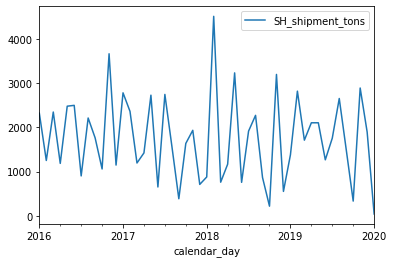

In [17]:
#Plotting The Shipments of 4" ANG
uni_data.plot()

In [18]:
scale = StandardScaler()

In [19]:
uni_data_scaled = scale.fit_transform(uni_data)

In [20]:
#matches value of index 36, last day in 2018 -> use 36 as limitation
scale.inverse_transform(uni_data_scaled[36])

array([1380.])

In [22]:
#Splitting time frames
TRAIN_SPLIT = 36
univariate_past_history = 3
univariate_future_target = 0

#training set
x_train_uni, y_train_uni = univariate_data(uni_data_scaled, 0, TRAIN_SPLIT,
                                            univariate_past_history, 
                                            univariate_future_target)
#test set
x_val_uni, y_val_uni = univariate_data(uni_data_scaled, TRAIN_SPLIT, None,
                                            univariate_past_history, 
                                            univariate_future_target)

In [23]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target shipments to predict')
print (y_train_uni[0])

Single window of past history
[[ 0.59913637]
 [-0.52261944]
 [ 0.62641949]]

 Target shipments to predict
[-0.59187658]


In [24]:
#function to show the appropriate time-step
def create_time_steps(length):
  return list(range(-length, 0))

In [25]:
#function for plotting
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/Users/jacosta3/.local/share/virtualenvs/pft-FTlP17jZ/lib/python3.7/site-packages/matplotlib/pyplot.py'>

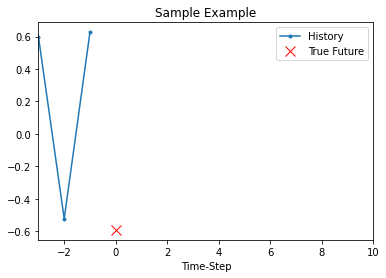

In [26]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [27]:
#setting seed for reproductability
tf.random.set_seed(42)

In [29]:
#setting batch size for 3 months (the size of a production cycle)
BATCH_SIZE = 6
BUFFER_SIZE = 60

#setting up memory and batch sizes
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
#no chace nor shuffle for validation
val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [30]:
x_train_uni.shape[-2:]

(3, 1)

In [31]:
#architecture
simple_lstm = keras.models.Sequential([
    keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    keras.layers.Dense(1)
])

#compiler
simple_lstm.compile(optimizer='adam', loss='mae')

In [32]:
for x,y in val_univariate.take(1):
    print(simple_lstm.predict(x).shape)

(6, 1)


In [34]:
#fitting the model
EPOCHS=5 # Number of iterations over the training set (in this case full batch)
EVALUATION_INTERVAL=36 # size of the data for evaluation, in this case the whole data set for this block

simple_lstm.fit(train_univariate, epochs=EPOCHS,
                steps_per_epoch=EVALUATION_INTERVAL,
                validation_data=val_univariate,
                validation_steps=12)

Train for 36 steps, validate for 12 steps
Epoch 1/5
36/36 [==============================] - 0s 9ms/step - loss: 0.9274 - val_loss: 0.8198
Epoch 2/5
36/36 [==============================] - 0s 8ms/step - loss: 0.9388 - val_loss: 0.8116
Epoch 3/5
36/36 [==============================] - 0s 7ms/step - loss: 0.9067 - val_loss: 0.8050
Epoch 4/5
36/36 [==============================] - 0s 12ms/step - loss: 0.9132 - val_loss: 0.8007
Epoch 5/5
36/36 [==============================] - 0s 10ms/step - loss: 0.9251 - val_loss: 0.7969


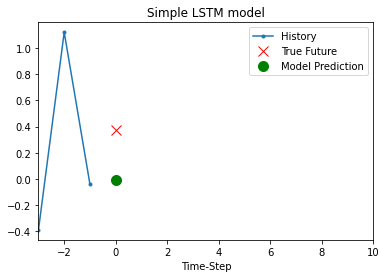

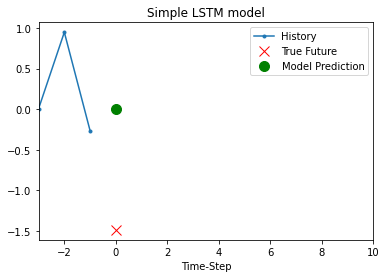

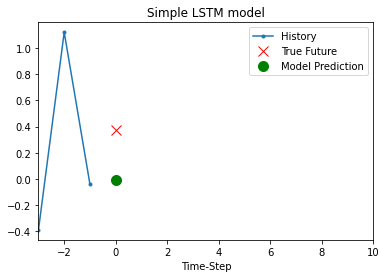

In [35]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

# Model Multivariate Monthly (One Block)

In [36]:
#test model with/without month
data = monthly.drop(columns=['calendar_day','year'])
#data = struct_indicators.drop(columns=['year','month'])

In [38]:
data.index = monthly['calendar_day']

In [39]:
data.month = data.month.astype(float)

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2936 entries, 2016-01-31 to 2020-01-31
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   month                       2936 non-null   float64 
 1   global_steel_utilization    2936 non-null   float64 
 2   fed_construction$B          2936 non-null   float64 
 3   state_local_construction$B  2936 non-null   float64 
 4   carbon_bar_ship_usa         2936 non-null   float64 
 5   carbon_bar_ship_canada      2936 non-null   float64 
 6   structural_ship_usa         2936 non-null   float64 
 7   structural_ship_canada      2936 non-null   float64 
 8   ism_manufacturing           2936 non-null   float64 
 9   ism_non_manufacturing       2936 non-null   float64 
 10  chicago_scrap$ST            2936 non-null   float64 
 11  block                       2936 non-null   category
 12  IN_tons                     2936 non-null   float64 
 13  

In [41]:
## select columns
columns = ['month',
       'state_local_construction$B',
       'carbon_bar_ship_canada', 
       'block', 'IN_tons', 'PR_ton',
       'SO_order_qty_sales_units', 'SH_shipment_tons']

data = data[columns]
data.shape

(2936, 8)

In [42]:
#select specific block
data = data[data['block']=='4" ANG']

In [43]:
#check data size
data.shape

(49, 8)

In [44]:
# #pick categories transformers 
#cat_attribs = ['block']
cat_attribs = ['block',]

ord_attribs = ['month',]
# #pick numerical transformers
#anum_attribs = list(data.drop(columns=['block']))
num_attribs = list(data.drop(columns=['block','month']))

In [45]:

#create pipeline to encode and scale variables
pipeline = ColumnTransformer([
    ('ord', MinMaxScaler(), ord_attribs),
    ('cat', OneHotEncoder(), cat_attribs),
    ('num', StandardScaler(), num_attribs),
])

In [46]:
#preparing data
data_prepared = pipeline.fit_transform(data)
#view categories
pipeline.transformers_

[('ord', MinMaxScaler(copy=True, feature_range=(0, 1)), ['month']),
 ('cat',
  OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
                handle_unknown='error', sparse=True),
  ['block']),
 ('num',
  StandardScaler(copy=True, with_mean=True, with_std=True),
  ['state_local_construction$B',
   'carbon_bar_ship_canada',
   'IN_tons',
   'PR_ton',
   'SO_order_qty_sales_units',
   'SH_shipment_tons'])]

In [47]:
#view data prepared
print(data_prepared[0])
print(data_prepared.shape)

[ 0.          1.         -1.44392161 -0.17748461  0.65917344  0.80217139
  0.05971609  0.59913637]
(49, 8)


In [48]:
#function to split multivariate data
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [49]:
#data split for all blocks by time frame
TRAIN_SPLIT = 36 #size of dataframe up to 2018
past_history = 3 # 4 weeks of data
future_target = 0 # how far out do we want to forecast 0-> next week
STEP = 1 # more than one if we don't want use all the data points in the sample

x_train_single, y_train_single = multivariate_data(data_prepared, data_prepared[:, -1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(data_prepared, data_prepared[:, -1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [50]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (3, 8)


In [51]:
#setting batch size for 3 months (the size of a production cycle)
BATCH_SIZE = 12 #2-3 times the size of the past_history
BUFFER_SIZE = 50 #size of data to shuffle, should be set slightly larger or equal to dataset size

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))#Creates tensor slices of data for keras model ingestion
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()#stores slices of data in cache, shuffles and stores to size batches 

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [52]:
#model architecture (TURN-OFF FIRST INSTANCE)
#del single_step_model
single_step_model = keras.models.Sequential()
single_step_model.add(keras.layers.LSTM(64, input_shape=x_train_single.shape[-2:])) # number of variables * 20
single_step_model.add(keras.layers.Dense(1)) #only one output layer

single_step_model.compile(optimizer=keras.optimizers.RMSprop(), loss='mae')

In [53]:
#parameters
EPOCHS=10
EVALUATION_INTERVAL=3

#clearing weights and any other remnants from models-past
keras.backend.clear_session()
#fitting the model
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=1)

Train for 3 steps, validate for 1 steps
Epoch 1/10
3/3 [==============================] - 4s 1s/step - loss: 0.8576 - val_loss: 0.7078
Epoch 2/10
3/3 [==============================] - 0s 17ms/step - loss: 0.8576 - val_loss: 0.7020
Epoch 3/10
3/3 [==============================] - 0s 20ms/step - loss: 0.8373 - val_loss: 0.7017
Epoch 4/10
3/3 [==============================] - 0s 25ms/step - loss: 0.8014 - val_loss: 0.6977
Epoch 5/10
3/3 [==============================] - 0s 26ms/step - loss: 0.7766 - val_loss: 0.6969
Epoch 6/10
3/3 [==============================] - 0s 22ms/step - loss: 0.7649 - val_loss: 0.6947
Epoch 7/10
3/3 [==============================] - 0s 14ms/step - loss: 0.7628 - val_loss: 0.6922
Epoch 8/10
3/3 [==============================] - 0s 19ms/step - loss: 0.7008 - val_loss: 0.6908
Epoch 9/10
3/3 [==============================] - 0s 17ms/step - loss: 0.7193 - val_loss: 0.6838
Epoch 10/10
3/3 [==============================] - 0s 17ms/step - loss: 0.6583 - val_loss

In [54]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

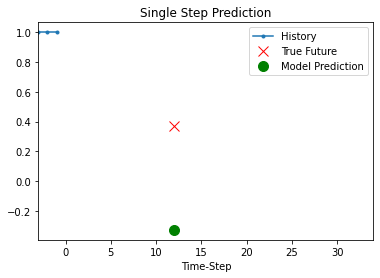

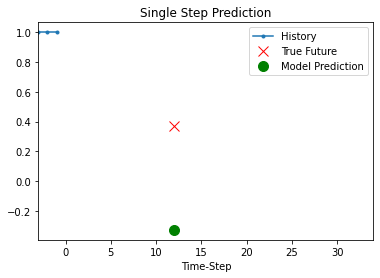

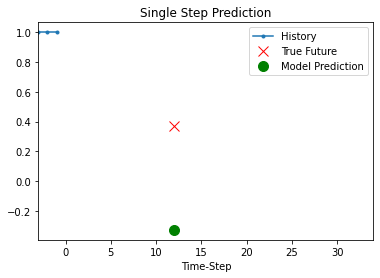

In [55]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

In [56]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x))

[[-0.3277108 ]
 [ 0.00431815]
 [-0.5711788 ]
 [-0.04388192]
 [ 0.11859038]
 [-0.7722044 ]
 [-0.1682332 ]
 [ 0.25176895]
 [-0.6736739 ]
 [-0.6041965 ]]


# Multiclass Multivariate Model Monthly 

In [57]:
#test model with/without month
data = monthly.drop(columns=['calendar_day','year'])
#data = struct_indicators.drop(columns=['year','month'])
data.index = monthly['calendar_day']

In [58]:
## select columns
columns = ['month',
       'carbon_bar_ship_canada', 
       'state_local_construction$B',
       'block', 'IN_tons', 'PR_ton',
       'SO_order_qty_sales_units', 'SH_shipment_tons']

data = data[columns]
data.shape

(2936, 8)

In [59]:
# #pick categories transformers 
#cat_attribs = ['block']
cat_attribs = ['block',]

ord_attribs = ['month']
# #pick numerical transformers
#anum_attribs = list(data.drop(columns=['block']))
num_attribs = list(data.drop(columns=['block', 'month']))

In [60]:
#create pipeline to encode and scale variables
pipeline = ColumnTransformer([
    ('ord', MinMaxScaler(), ord_attribs),
    ('cat', OneHotEncoder(sparse=False), cat_attribs),
    ('num', StandardScaler(), num_attribs),
])

In [61]:
#preparing data
data_prepared = pipeline.fit_transform(data)

In [62]:
#see transformed values of input
pipeline.transformers_

[('ord', MinMaxScaler(copy=True, feature_range=(0, 1)), ['month']),
 ('cat',
  OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
                handle_unknown='error', sparse=False),
  ['block']),
 ('num',
  StandardScaler(copy=True, with_mean=True, with_std=True),
  ['carbon_bar_ship_canada',
   'state_local_construction$B',
   'IN_tons',
   'PR_ton',
   'SO_order_qty_sales_units',
   'SH_shipment_tons'])]

In [63]:
#checking data size
data_prepared.shape

(2936, 82)

In [64]:
#making sure data is numpy array
type(data_prepared)

numpy.ndarray

In [67]:
#checking spot for train_split
monthly.iloc[2180:2200,:]

,calendar_day,year,month,global_steel_utilization,fed_construction$B,state_local_construction$B,carbon_bar_ship_usa,carbon_bar_ship_canada,structural_ship_usa,structural_ship_canada,ism_manufacturing,ism_non_manufacturing,chicago_scrap$ST,block,IN_tons,PR_ton,SO_order_qty_sales_units,SH_shipment_tons
2180,2018-12-31,2018,12,0.7620,1783.0,19153.0,177300.0,21900.0,174200.0,25500.0,54.3,58.0,405.0,"8 X 6"" ANG",691.380001,0.0,0.0000,41.0
2181,2018-12-31,2018,12,0.7620,1783.0,19153.0,177300.0,21900.0,174200.0,25500.0,54.3,58.0,405.0,"3/8"" SQR",0.000000,0.0,0.0000,0.0
2182,2018-12-31,2018,12,0.7620,1783.0,19153.0,177300.0,21900.0,174200.0,25500.0,54.3,58.0,405.0,"3/16X3/4"" FLT",0.000000,0.0,0.0000,0.0
2183,2018-12-31,2018,12,0.7620,1783.0,19153.0,177300.0,21900.0,174200.0,25500.0,54.3,58.0,405.0,"4 X 3-1/2"" ANG",200.409996,0.0,4.5500,10.0
2184,2018-12-31,2018,12,0.7620,1783.0,19153.0,177300.0,21900.0,174200.0,25500.0,54.3,58.0,405.0,"1"" SB FLT",134.595002,0.0,28.1335,114.0
2185,2018-12-31,2018,12,0.7620,1783.0,19153.0,177300.0,21900.0,174200.0,25500.0,54.3,58.0,405.0,1-1/2 SQR,2.677000,0.0,0.0000,3.0
2186,2018-12-31,2018,12,0.7620,1783.0,19153.0,177300.0,21900.0,174200.0,25500.0,54.3,58.0,405.0,MC12X10.6,122.959993,0.0,4.2400,8.0
2187,2018-12-31,2018,12,0.7620,1783.0,19153.0,177300.0,21900.0,174200.0,25500.0,54.3,58.0,405.0,"6 X 3-1/2"" ANG",16521.572004,-3.0,79.8060,109.0
2188,2018-12-31,2018,12,0.7620,1783.0,19153.0,177300.0,21900.0,174200.0,25500.0,54.3,58.0,405.0,"4"" FLT",75.661000,0.0,48.2460,79.0
2189,2018-12-31,2018,12,0.7620,1783.0,19153.0,177300.0,21900.0,174200.0,25500.0,54.3,58.0,405.0,"6"" FLT",26724.191207,1741.0,755.0565,279.0


In [68]:
#data split for all blocks by time frame
TRAIN_SPLIT2 = 2190 #size of dataframe up to 2018
past_history = 65 # 4 weeks of data (~65 blocks/week X 4 weeks )
future_target = 65 # how far out do we want to forecast 0-> next week
STEP = 1 # more than one if we don't want use all the data points in the sample

x_train_single, y_train_single = multivariate_data(data_prepared, data_prepared[:, -1], 0,
                                                   TRAIN_SPLIT2, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(data_prepared, data_prepared[:, -1],
                                               TRAIN_SPLIT2, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [69]:
print ('Single window of train past history : {}'.format(x_train_single[0].shape))
print ('Single window of prediction past history : {}'.format(x_val_single[0].shape))

Single window of train past history : (65, 82)
Single window of prediction past history : (65, 82)


In [70]:
#setting batch size for 2-3 months (the size of a production cycle)
BATCH_SIZE = 195 #2-3 times the size of the past_history
BUFFER_SIZE = 3000 #size of data to shuffle, should be set slightly larger or equal to dataset size

##NEED TO LOOK UP AND EXPLAIN THIS
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single)) #Creates tensor slices of data for keras model ingestion
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat() #stores slices of data in cache, shuffles and stores to size batches 

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat() 

In [71]:
train_data_single

<RepeatDataset shapes: ((None, 65, 82), (None,)), types: (tf.float64, tf.float64)>

In [72]:
#deleting saved model for re-runs (TURN-OFF FIRST INSTANCE)
#del single_step_multiclass
#creating model architecture
single_step_multiclass = keras.models.Sequential()
single_step_multiclass.add(keras.layers.LSTM(328, input_shape=x_train_single.shape[-2:])) # number of variables * 4
single_step_multiclass.add(keras.layers.Dense(1)) #only one output layer

single_step_multiclass.compile(optimizer=keras.optimizers.RMSprop(), loss='mae')

In [73]:
#parameters
EPOCHS=8 #number of times to run train 
EVALUATION_INTERVAL=12 #how many steps are taken during epoch - 3 years worth of data(9600 points) divided by steps of 780 points (8/weeks)

#clearing weights and any other remnants from models-past
keras.backend.clear_session()
#fitting the model
single_step_history = single_step_multiclass.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=4)

Train for 12 steps, validate for 4 steps
Epoch 1/8
12/12 [==============================] - 16s 1s/step - loss: 0.5559 - val_loss: 0.4449
Epoch 2/8
12/12 [==============================] - 13s 1s/step - loss: 0.5280 - val_loss: 0.4153
Epoch 3/8
12/12 [==============================] - 14s 1s/step - loss: 0.5108 - val_loss: 0.4298
Epoch 4/8
12/12 [==============================] - 15s 1s/step - loss: 0.5112 - val_loss: 0.4138
Epoch 5/8
12/12 [==============================] - 14s 1s/step - loss: 0.5110 - val_loss: 0.4076
Epoch 6/8
12/12 [==============================] - 13s 1s/step - loss: 0.5055 - val_loss: 0.4126
Epoch 7/8
12/12 [==============================] - 15s 1s/step - loss: 0.4880 - val_loss: 0.4080
Epoch 8/8
12/12 [==============================] - 13s 1s/step - loss: 0.5032 - val_loss: 0.4058


In [74]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

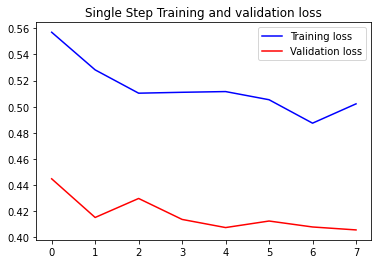

In [75]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

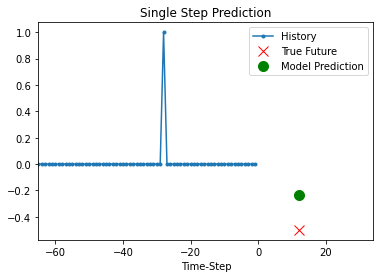

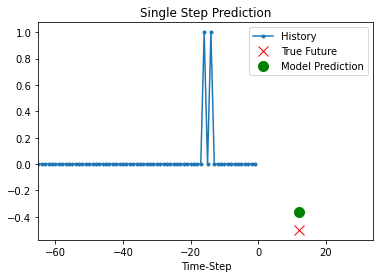

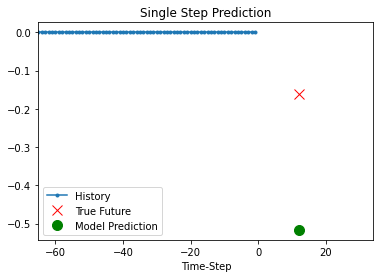

In [76]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_multiclass.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

In [78]:
for x, y in val_data_single.take(1):
  print(single_step_multiclass.predict(x).shape)

(195, 1)
